# **CDS Project: Part 3**

*Institute of Software Security (E22)*  
*Hamburg University of Technology*  

## Learning objectives
---

- Choose an ML model architecture for vulnerability prediction
- Preprocess the dataset you created in project part 2 to fit the model you selected
- Split the dataset for cross validation
- Create the model training pipeline, train the model using the train set and optimize the model using the test set
- Create loss graphs of the learning behaviour
- Generate predictions for the validation set
- Evaluate the results using appropriate metrics (add questions: reduce overfitting? optional 5-fold cross validation)


## Materials
---

- Lecture Slides 2, 3, 5 and 6, 9.
- PyTorch Documentation: [Datasets and Data Loaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) 
- 


## Project Description

In this project, you will create, train and evaluate your own machine learning model to predict vulnerabilities in source code. In addition, you will preprocess the data to prepare it to be used in the learning pipeline.
You will be using the dataset created in part 2 in this part. 

## **Task 1**

- There are several ML model architectures that you can use for vulnerabilitiy prediction such as RNN, CNN, Multilabel Perceptron (MLP), Gated Recurrent Units (GRU) and so on. Choose a suitable ML model architecture for your project based on the strenghts and weaknesses of these algorithms.

- For the model architecture, you can choose from 2 paths:
  1. Preprocess the functions into vectors and continue the learning process similar to project 1.
  For instance, the code in the dataset needs to be converted into some type of vector representation that can be processed by a machine. After selecting a suitable model, preprocess the content in your dataset accordingly. Several models are available to preprocess code data such as:
    - Code2Vec: https://code2vec.org/
    - CodeBERT: https://github.com/microsoft/CodeBERT/tree/master/UniXcoder
    - CodeT5: https://github.com/salesforce/CodeT5

  2. Choose a model architecture that is capable of handeling raw text inputs (LSTM, GRU, etc.) as an input layer. Further information on text processing using pytorch:
    - https://pytorch.org/text/stable/index.html
    - https://pytorch.org/tutorials/


## Task 2

- Split your dataset appropriately into train, test, and validation set and justify your split.  

In [3]:
!pip install torch torchvision torchaudio

  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: sympy
    Found existing installation: sympy 1.10.1
    Uninstalling sympy-1.10.1:
      Successfully uninstalled sympy-1.10.1


In [16]:
# TODO: Load the dataset
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import re
import torch.nn as nn

file_path = "C:/CyDS/vulnerability_dataset_processed.csv"
df = pd.read_csv(file_path)
# TODO: Split the dataset into train, test and validation set

In [17]:
# Tokenizer
def tokenize_code(code):
    return re.findall(r"[A-Za-z_]\w*|==|!=|<=|>=|&&|\|\||[^\s]", code)

# Build vocabulary
def build_vocab(codes, min_freq=2):
    counter = Counter()
    for code in codes:
        tokens = tokenize_code(code)
        counter.update(tokens)
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for token, freq in counter.items():
        if freq >= min_freq:
            vocab[token] = len(vocab)
    return vocab

# Encode and pad
def encode(tokens, vocab):
    return [vocab.get(token, vocab["<UNK>"]) for token in tokens]

def pad_sequence(seq, max_len, pad_idx=0):
    return seq[:max_len] + [pad_idx] * max(0, max_len - len(seq))

# Build vocab and encode the dataset
MAX_SEQ_LEN = 300
codes = df["code"].tolist()
labels = df["label"].tolist()
vocab = build_vocab(codes)

encoded_codes = [pad_sequence(encode(tokenize_code(code), vocab), MAX_SEQ_LEN) for code in codes]
labels = torch.tensor(labels, dtype=torch.long)

In [18]:
class CodeDataset(Dataset):
    def __init__(self, codes, labels):
        self.codes = torch.tensor(codes, dtype=torch.long)
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.codes[idx], self.labels[idx]

train_dataset = CodeDataset(encoded_codes, labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

## Task 3
- Create a preprocessing and training/test pipeline. This can also be done in separate steps.
- Train the model on a small dataset (e.g.: 1000 samples depending on the computational capacity) and make sure everything is working properly
- Show a graph showing the changes in loss function druring the training epochs 
- Select proper metrics to evaluate the performance of the model
- If everything works well, then change the model parameters (e.g: number of neurons, layer depth) and regenerate the results. Comapare these results with your previous results and elaborate your findings.

Epoch 1 | Train Loss: 0.7161
Epoch 2 | Train Loss: 0.6597
Epoch 3 | Train Loss: 0.6364
Epoch 4 | Train Loss: 0.6107
Epoch 5 | Train Loss: 0.5813
Epoch 6 | Train Loss: 0.5684
Epoch 7 | Train Loss: 0.5446
Epoch 8 | Train Loss: 0.5286
Epoch 9 | Train Loss: 0.5159
Epoch 10 | Train Loss: 0.5076
Epoch 11 | Train Loss: 0.5018
Epoch 12 | Train Loss: 0.4998
Epoch 13 | Train Loss: 0.5056
Epoch 14 | Train Loss: 0.4799
Epoch 15 | Train Loss: 0.4730
Epoch 16 | Train Loss: 0.4541
Epoch 17 | Train Loss: 0.4522
Epoch 18 | Train Loss: 0.4564
Epoch 19 | Train Loss: 0.4642
Epoch 20 | Train Loss: 0.4511
Epoch 21 | Train Loss: 0.4465
Epoch 22 | Train Loss: 0.4538
Epoch 23 | Train Loss: 0.4486
Epoch 24 | Train Loss: 0.4431
Epoch 25 | Train Loss: 0.4474
Epoch 26 | Train Loss: 0.4443
Epoch 27 | Train Loss: 0.4516
Epoch 28 | Train Loss: 0.4321
Epoch 29 | Train Loss: 0.4252
Epoch 30 | Train Loss: 0.4203


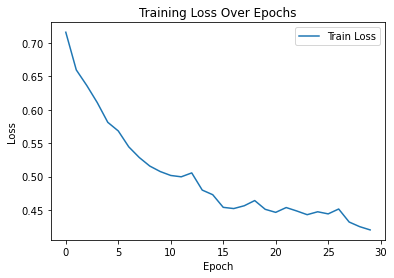


--- Test Evaluation ---

Accuracy: 0.5145 | Precision: 0.5165 | Recall: 0.6714 | F1 Score: 0.5839


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import re
import pickle
from collections import Counter

# ==========================
# Tokenization & Vocabulary
# ==========================

def tokenize_code(code):
    return re.findall(r'\w+|\S', str(code))

def build_vocab(all_codes, max_vocab_size=10000):
    counter = Counter()
    for code in all_codes:
        tokens = tokenize_code(code)
        counter.update(tokens)

    vocab = {'<PAD>': 0, '<UNK>': 1}
    for i, (token, _) in enumerate(counter.most_common(max_vocab_size - 2), 2):
        vocab[token] = i

    # Save vocab for later use
    with open("vocab.pkl", "wb") as f:
        pickle.dump(vocab, f)

    return vocab

def encode_code(code, vocab, max_length=300):
    tokens = tokenize_code(code)
    indices = [vocab.get(token, vocab['<UNK>']) for token in tokens]
    return indices[:max_length]

# ==========================
# Dataset Class
# ==========================

class CodeDataset(Dataset):
    def __init__(self, dataframe, vocab, max_length=300):  # Corrected __init__
        self.codes = dataframe['code'].tolist()
        self.labels = dataframe['label'].tolist()
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):  # Corrected __len__
        return len(self.codes)

    def __getitem__(self, idx):  # Corrected __getitem__
        code = self.codes[idx]
        label = self.labels[idx]
        encoded = encode_code(code, self.vocab, self.max_length)
        return torch.tensor(encoded), torch.tensor(label)

def pad_collate(batch):
    codes, labels = zip(*batch)
    padded_codes = nn.utils.rnn.pad_sequence(codes, batch_first=True, padding_value=0)
    return padded_codes, torch.tensor(labels)

# ==========================
# RNN Model
# ==========================

class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=128):  # Corrected __init__
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, hidden = self.rnn(x)
        out = self.fc(hidden.squeeze(0))
        return self.sigmoid(out)

# ==========================
# Training & Evaluation
# ==========================

def train_model(model, train_loader, val_loader=None, epochs=30, lr=0.0005):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()
    train_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.long(), y_batch.float().unsqueeze(1)
            optimizer.zero_grad()
            preds = model(x_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f}")

    # Plot only training loss
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.show()
    
    
def evaluate_model(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch = x_batch.long()
            preds = model(x_batch).squeeze()
            preds = torch.round(preds)
            y_pred.extend(preds.tolist())
            y_true.extend(y_batch.tolist())

    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    print(f"\nAccuracy: {acc:.4f} | Precision: {p:.4f} | Recall: {r:.4f} | F1 Score: {f1:.4f}")

# ==========================
# Main
# ==========================

def main():
    # Load CSVs (update paths if needed)
    train_df = pd.read_csv("C:/CyDS/train.csv")
    val_df = pd.read_csv("C:/CyDS/val.csv")
    test_df = pd.read_csv("C:/CyDS/test.csv")

    # Build vocab from train only
    vocab = build_vocab(train_df['code'])

    # Dataset and DataLoader
    train_data = CodeDataset(train_df, vocab)
    val_data = CodeDataset(val_df, vocab)
    test_data = CodeDataset(test_df, vocab)

    train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=pad_collate)
    val_loader = DataLoader(val_data, batch_size=16, shuffle=False, collate_fn=pad_collate)
    test_loader = DataLoader(test_data, batch_size=16, shuffle=False, collate_fn=pad_collate)

    # Model
    model = RNNClassifier(vocab_size=len(vocab))

    # Train
    train_model(model, train_loader, val_loader)

    # Evaluate
    print("\n--- Test Evaluation ---")
    evaluate_model(model, test_loader)

if __name__ == "__main__":
    main()
